In [1]:
#
# phase4 :
#   Logistic regression Bayesian learning
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32,exception_verbosity=high"
import theano
import theano.tensor as T
import config
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.moon as moon
import seaborn as sns
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [6]:
# parameter setup
EXP = 1
SAVE_FLAG = True
DIMX = 2
model = moon.Logistic(DIMX)
ROOT = '../report/figs/bayes/logistic/exp%d/'%EXP
model.setPriorCenter(0.0)
print 'save flag : %s' % SAVE_FLAG

save flag : False


In [7]:
## loading from past experiments

hist = np.load(ROOT+'/record_L4.npz')
data = { 'x': hist['x'], 'y': hist['y'] }
PRIOR_WEIGHT = hist['prior_weight']

data generated:
	x : (400, 2)
	y : (400,), 	values : [ 0.  1.]


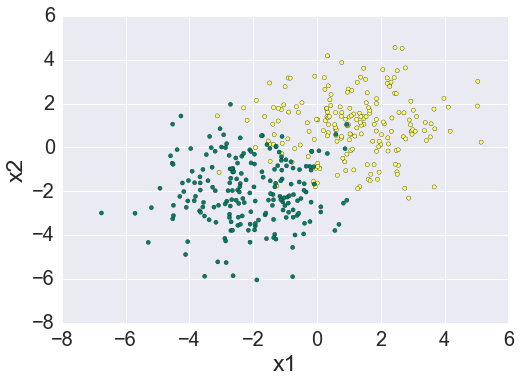

In [13]:
# data generation, 2D
SIZE = 400
S1 = int(SIZE*.5)
S2 = int(SIZE*.5)

blob_scale = np.asarray([0.7,0.7])
y1 = np.ones(S1);   x1 = npr.randn( S1, DIMX )/blob_scale + np.asarray([1,1])
y2 = np.zeros(S2);  x2 = npr.randn( S2, DIMX )/blob_scale + np.asarray([-2,-2])


xn = np.concatenate([x1,x2],axis=0)
yn = np.concatenate([y1,y2],axis=0)
data = {'x':xn,'y':yn}
print ('data generated:\n\tx : %s\n\ty : %s, \tvalues : %s' %(data['x'].shape,data['y'].shape,np.unique(data['y'])))
plotZ.category2d(data['x'],data['y'],dotarea=17,cmap='summer')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('x1',fontsize=23); plt.ylabel('x2',fontsize=23)
if SAVE_FLAG:
    plt.savefig(ROOT+'/data.png')

In [16]:
# parameter setup
PRIOR_WEIGHT = 0.05

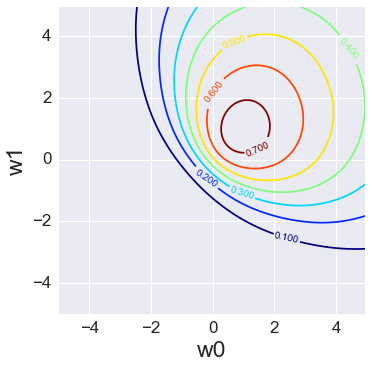

In [8]:
# plot true posterior

LOW,HIGH = -5,+5
GAP = (HIGH - LOW)/200.
gps, g1, g2 = mathZ.gridPoints( (LOW,HIGH,GAP), (LOW,HIGH,GAP) )
L = gps.shape[0]

xname = 'w0'; yname = 'w1'
INDEX = [0,1]
DEFAULT = 0
BIAS = 0

ws = np.ones( (L, DIMX) ) * DEFAULT
ws[:,INDEX[0]] = gps[:,0]
ws[:,INDEX[1]] = gps[:,1]
bs = np.ones(L)*BIAS 
logs_,logall = model.nlogPy_xw(data['x'],data['y'],ws,bs*5)

logs = logs_  + model.nlogPw2(ws)*PRIOR_WEIGHT

pws = np.exp( logs.reshape(g1.shape[1],g2.shape[0]) )
fig = plt.figure()
CS = plt.contour(g1,g2,pws,cmap='jet')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.xlabel(xname,fontsize=23); plt.ylabel(yname,fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=17)
# plt.title('p(w|x,y) unnormalised', fontsize=17)
if SAVE_FLAG:
    plt.savefig(ROOT+'/posterior.png')
plt.show()


In [67]:
##
## NF parameter setup
##
NUMITER = 10000
SAMPLINGNUM = 20
NUM_LAYERS = 32

NF_TYPE, STD = 'normal', 1.0
# NF_TYPE, STD = 'uniform', 4.0

DIMNF = DIMX+1
print('Variational model setup:\n\tnum-layers : %d\n\tdim : %d\n\tnum-sampling : %d'%(NUM_LAYERS,DIMNF,SAMPLINGNUM))

Variational model setup:
	num-layers : 32
	dim : 3
	num-sampling : 20


In [68]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIMNF, numlayers=NUM_LAYERS,noisestd=STD, z0type=NF_TYPE )
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)                 # z = L * ( DIMNF )

# matching latent variables to parameters
wt = z[:,:DIMX]
bt = T.squeeze( z[:,-1] )
# bt = utils.theanoGeneral.sharedf([0]*SAMPLINGNUM)

print('TensorVariable setup,\n\twt, (L,dimx) %s\n\tbt, (L ,   ) %s\n\tz , (L,dimx) %s\n\tlogqz,       %s' 
      % (wt.shape.eval(), bt.shape.eval(), z.shape.eval(), logqz.shape.eval()) )

TensorVariable setup,
	wt, (L,dimx) [20  2]
	bt, (L ,   ) [20]
	z , (L,dimx) [20  3]
	logqz,       [20]


In [69]:
# COST
x = utils.theanoGeneral.sharedf(data['x'])
y = utils.theanoGeneral.sharedf(data['y'])

logpy_xw, logpy_xw_all = model.logPy_xw(x,y,wt,bt)
logpw = model.logPw2(wt)
print ('data input:\n\tx : %s\n\ty : %s'%(x.shape.eval(),y.shape.eval()))
print ('model densities:\n\tlog( p(y|x,w) ) : %s\n\tlog( p(w) )     : %s'
       %(logpy_xw.shape.eval(),logpw.shape.eval()))

data input:
	x : [400   2]
	y : [400]
model densities:
	log( p(y|x,w) ) : [20]
	log( p(w) )     : [20]


In [70]:
# ELBO
logpxyw = logpy_xw + logpw*PRIOR_WEIGHT
cost = T.mean( logqz - logpxyw )  # negative-ELBO

# gradients reading
params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [71]:
# optimisor setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.005,momentum=0.5,decay=0.0005)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxyw), T.mean(logqz), z, logpy_xw_all, logpw ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [72]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [73]:
# training
keys = ['cost','pxz','qz','zsamples','logpy_xw','logpw']
record = {}

for k in keys:
    record[k] = []

for i in range(NUMITER):
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )        

for k in keys:
    record[k] = np.asarray( record[k] )

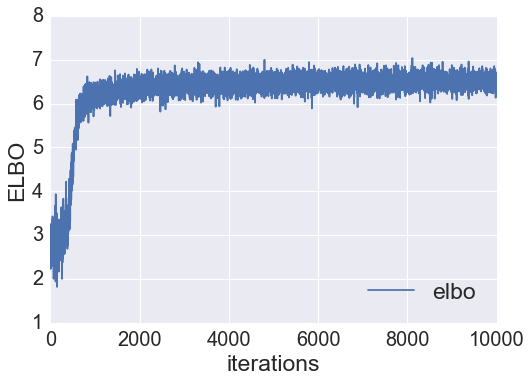

In [74]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='elbo')
plt.xlabel('iterations',fontsize=23)
plt.ylabel('ELBO',fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.plot( xs, record['pxz'], '-', label='log-pxz')
#plt.plot( xs, record['qz'], '-', label='log-qz')
plt.legend(fontsize=23,loc=4)
if SAVE_FLAG:
    plt.savefig(ROOT+'/elbo_L%d.png'% NUM_LAYERS)
plt.show()

../report/figs/bayes/logistic/exp1/


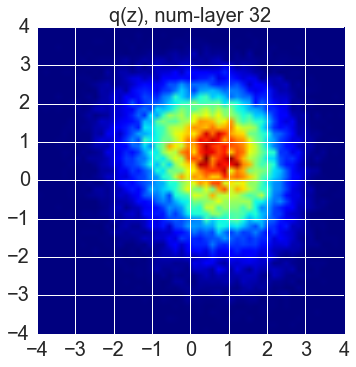

In [75]:
# estimated posterior
xlims = (-4,+4)
ylims = (-4,+4)
es, zs = fez2()
AXES = (0,1)
heatmap, xedges, yedges = np.histogram2d( zs[:,AXES[0]], zs[:,AXES[1]], bins=50)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='jet')
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('q(z), num-layer %d' % (NUM_LAYERS), fontsize=20)
if SAVE_FLAG:
    plt.savefig( ROOT+'/qz_L%d.png' %NUM_LAYERS)
print ROOT

In [76]:
SAVEPATH = ROOT+'/record_L%d.npz'%NUM_LAYERS
np.savez(SAVEPATH, x = data['x'], y=data['y'], 
         prior_weight=PRIOR_WEIGHT, numiter=NUMITER,
        numlayers=NUM_LAYERS, nftype=NF_TYPE, std=STD,
        cost=record['cost'], zs=zs )

(50000, 3)


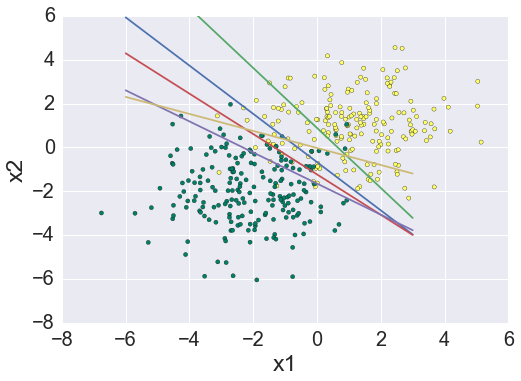

In [39]:
print zs.shape
IDS = npr.choice(zs.shape[0],5,replace=False)
# IDS = IDS
plotZ.category2d(data['x'],data['y'],dotarea=17,cmap='summer')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('x1',fontsize=23); plt.ylabel('x2',fontsize=23)
# axes = plt.axes
axes = plt.gca()
xlims, ylims = axes.get_xlim(), axes.get_ylim()
# plt.savefig(ROOT+'/data.png')
X1, X2 = -6., +3.
for i, idx in enumerate(IDS):
    [w1,w2,b] = zs[idx,:]
    Y1 = ( -w1*X1-b )/ w2
    Y2 = ( -w1*X2-b )/ w2
    plt.plot([X1,X2],[Y1,Y2],'-')
plt.xlim(xlims); plt.ylim(ylims)
# if SAVE_FLAG:
#     plt.savefig(ROOT+'/boarders.png')
plt.show()
    

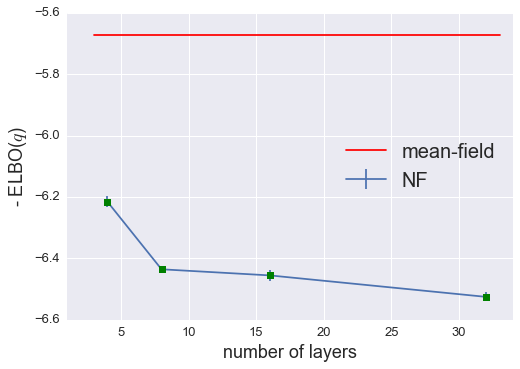

In [84]:
## INDEPENDENT
##     Statistica of the variational bound
##

NUM_LS = [4,8,16,32]

record_mf = np.load( ROOT + '/../mf/record.npz' )
cost_mf = np.mean( record_mf['cost'][-500:] )

rs = list()
costs = list()
for i, L in enumerate(NUM_LS):
    rs.append(  np.load(ROOT+'/record_L%d.npz'%L) )
    costs.append( -rs[-1]['cost'][-500:] )
costs = np.asarray( costs )
bars = [ np.var(costs[i]) for i in range(len(NUM_LS)) ]
costs = np.mean(costs,axis=1)

plt.errorbar(NUM_LS,-costs,yerr=bars,label='NF')
plt.plot( NUM_LS, -costs, 'sg')
plt.plot( [3,33],[cost_mf,cost_mf],'-r',label='mean-field')
    
plt.xlabel('number of layers',fontsize=18)
plt.ylabel('- ELBO($q$)',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlim([1,NUM_LS[-1]+2])
plt.legend(fontsize=20,loc='center right')
plt.savefig(ROOT+'/ELBOvsL.png')


In [76]:
##
## DEBUGGING
##
print record.keys()
print record['cost'][:4]
print record['pxz'][:4]
print record['qz'][:4]
print record['zsamples'].shape
print record['logpy_xw'].shape
print record['logpw'].shape
logpy_xw = np.mean(record['logpy_xw'],axis=2)
plt.hist(logpy_xw[0,:])
plt.hist(logpy_xw[1,:])
print logpy_xw[2,:]
print np.mean( record['logpy_xw'][2,7,:] )
zzss = record['zsamples']
# ITER = 0; plt.plot( zzss[ITER,:,0], zzss[ITER,:,1], 's', label='iter-%d'%ITER )
# ITER = 1; plt.plot( zzss[ITER,:,0], zzss[ITER,:,1], 's', label='iter-%d'%ITER )
ITER = 2; PID = 1; plt.plot( zzss[ITER,PID,0], zzss[ITER,PID,1], 'o', label='iter-%d'%ITER )
ITER = 2; PID = 6; plt.plot( zzss[ITER,PID,0], zzss[ITER,PID,1], 'rs', label='iter-%d'%ITER )
plt.xlim([-5,+5]); plt.ylim([-5,+5])
lg = plt.legend(fontsize=17)

['pxz', 'logpy_xw', 'zsamples', 'qz', 'cost', 'logpw']
[-0.50898346 -0.47311138         inf         nan]
[-2.04594965 -2.22107977        -inf         nan]
[-2.55493331 -2.69419122 -2.97923589         nan]
(1000, 20, 2)
(1000, 20, 400)
(1000, 20)
